In [55]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import combinations

In [2]:
d= np.loadtxt('prices.txt', dtype=float)

In [3]:
d

array([[38.25, 69.06, 62.08, ..., 24.02, 76.03, 27.5 ],
       [38.11, 69.98, 62.39, ..., 24.04, 76.05, 27.54],
       [37.9 , 69.56, 62.82, ..., 23.76, 75.66, 27.55],
       ...,
       [36.58, 50.8 , 44.25, ..., 15.81, 80.93, 31.83],
       [36.43, 51.19, 44.02, ..., 15.75, 80.8 , 31.78],
       [36.24, 50.64, 43.43, ..., 15.74, 80.5 , 31.59]])

In [4]:
d= d.T


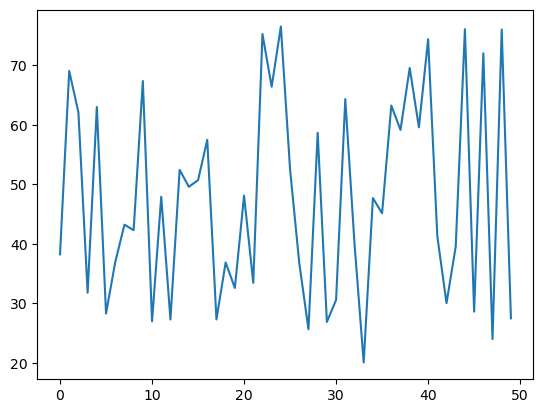

In [5]:
plt.plot(d[:,0])
plt.show()

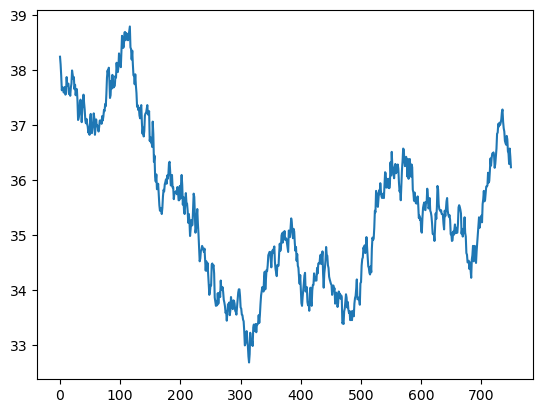

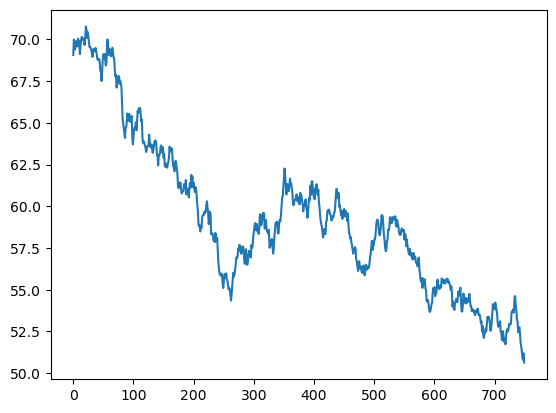

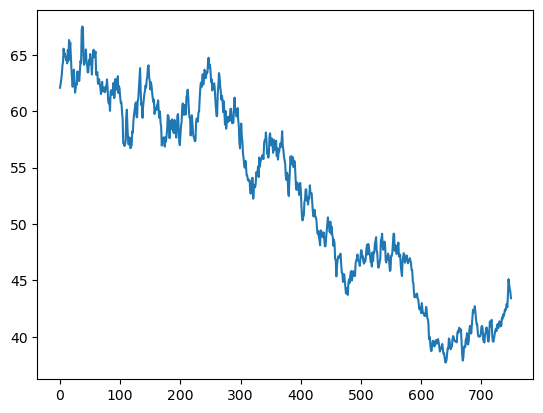

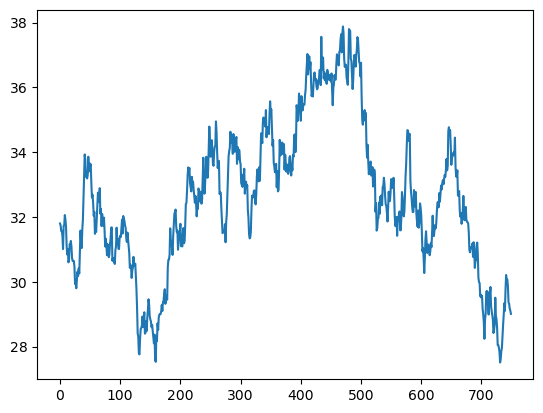

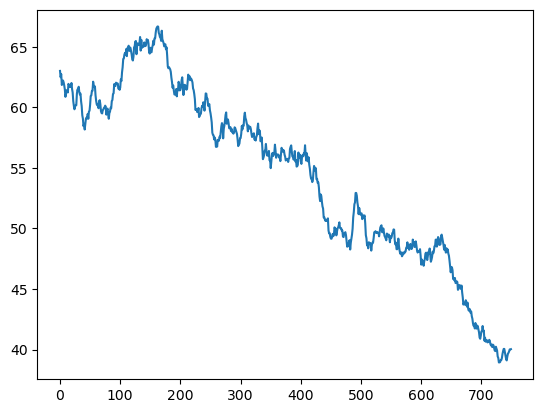

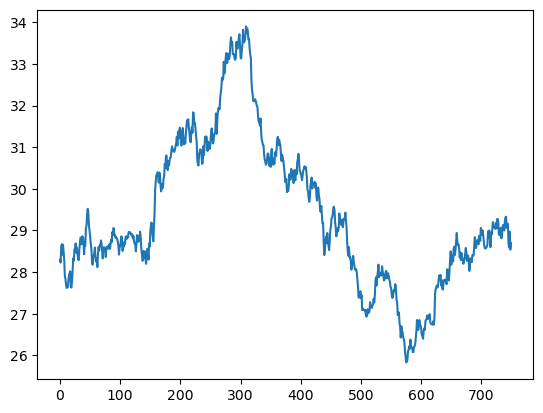

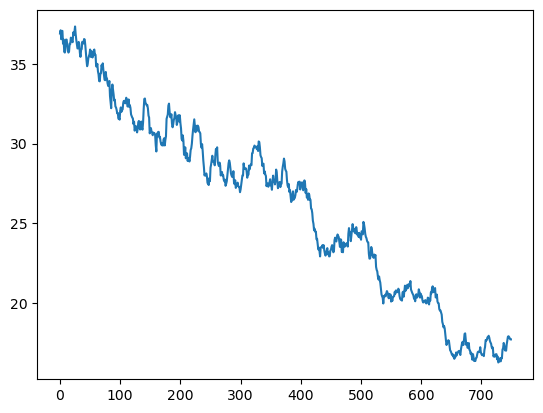

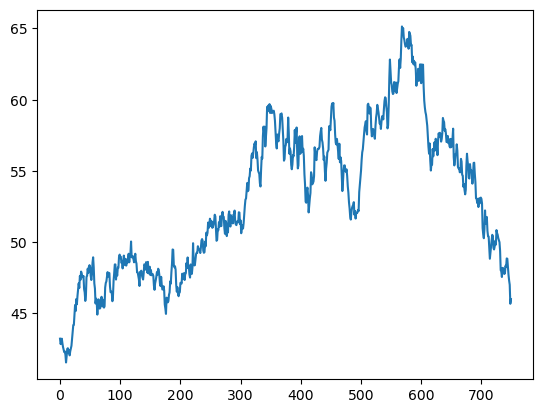

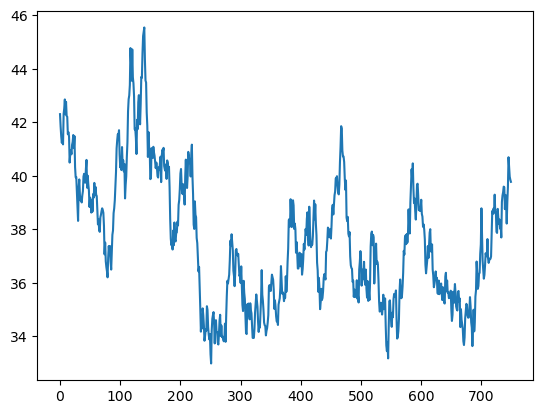

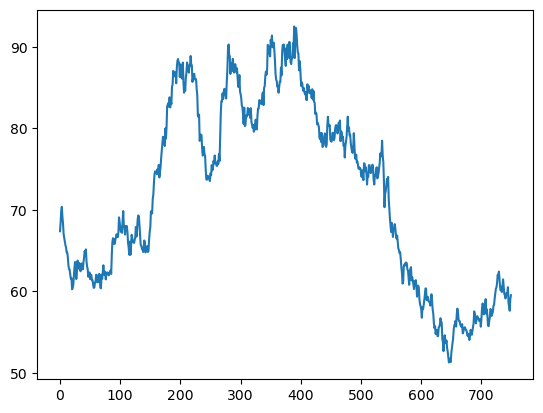

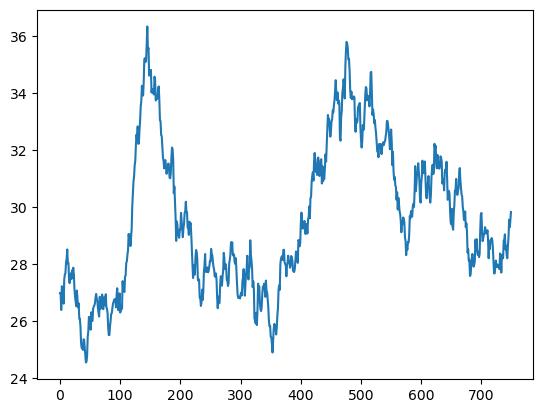

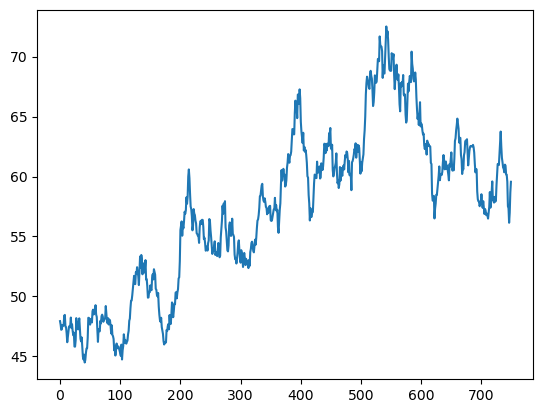

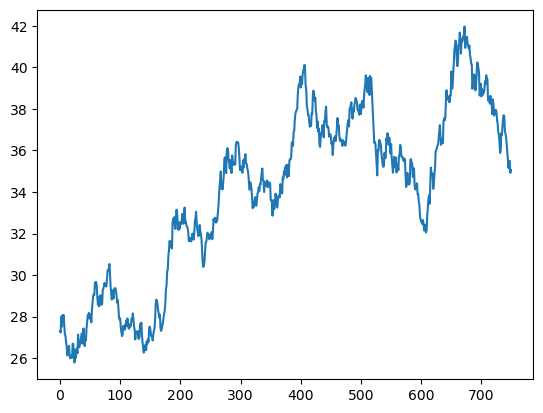

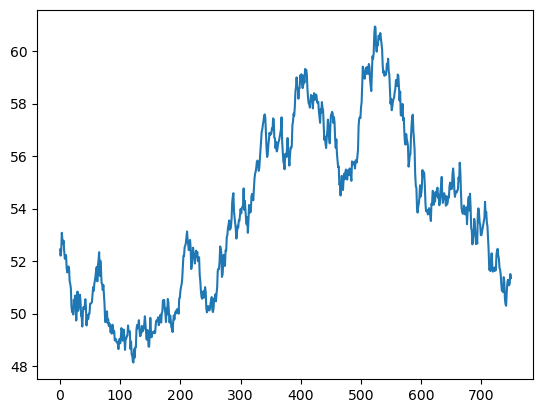

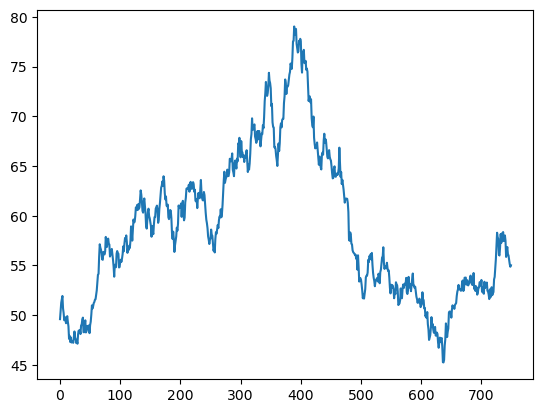

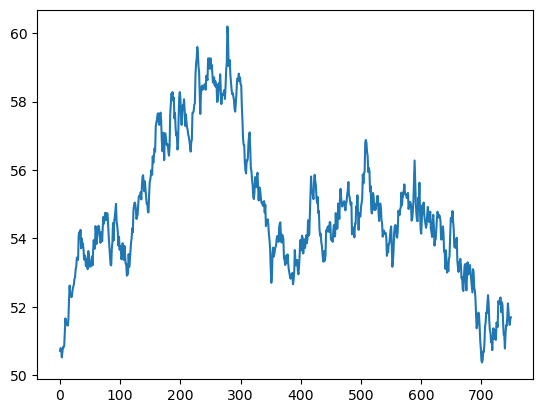

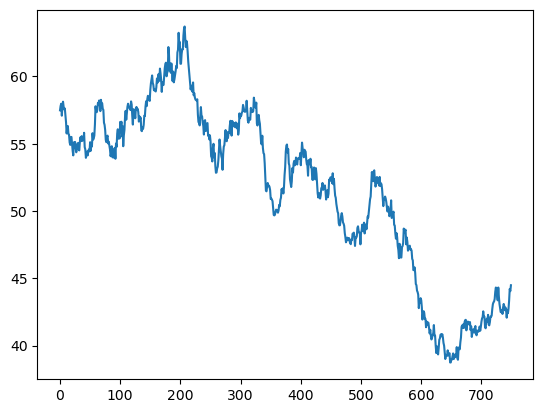

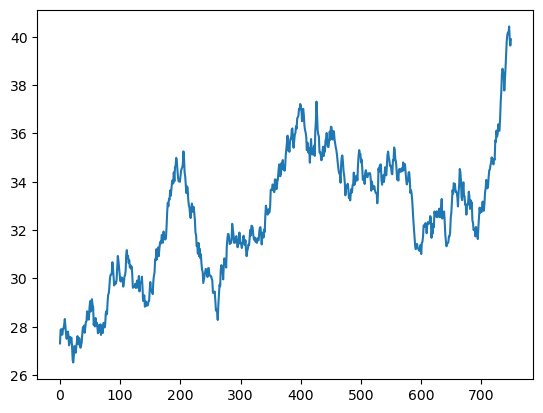

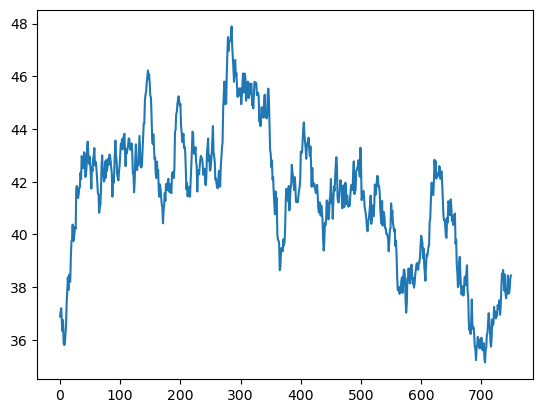

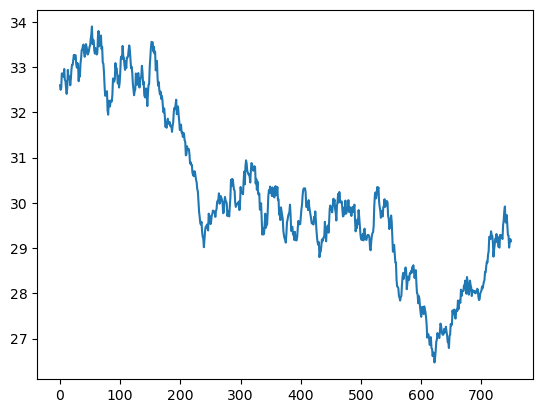

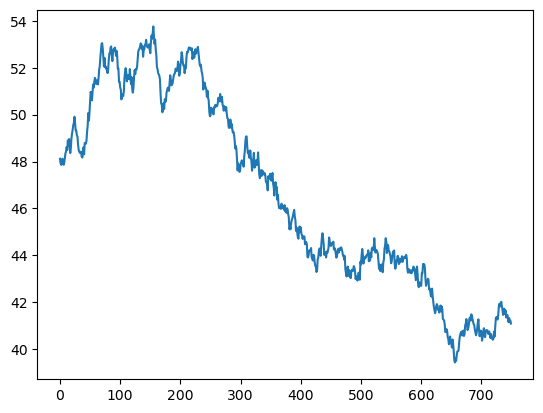

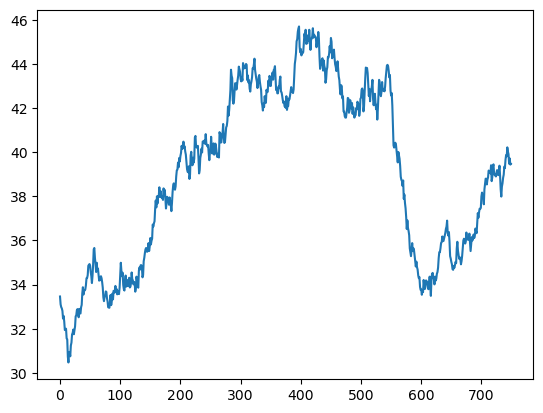

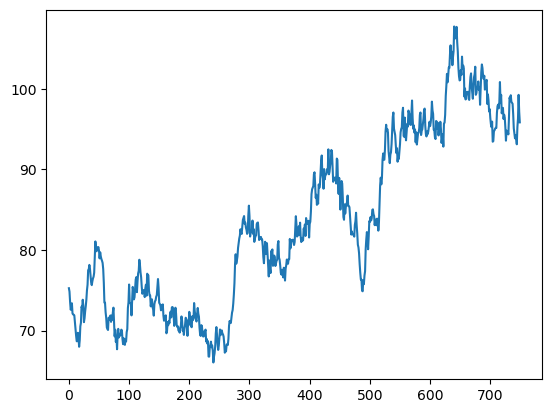

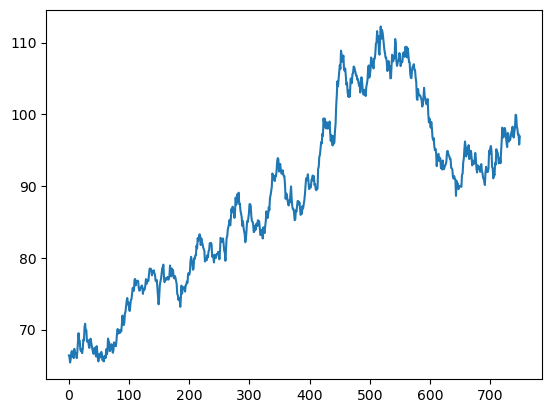

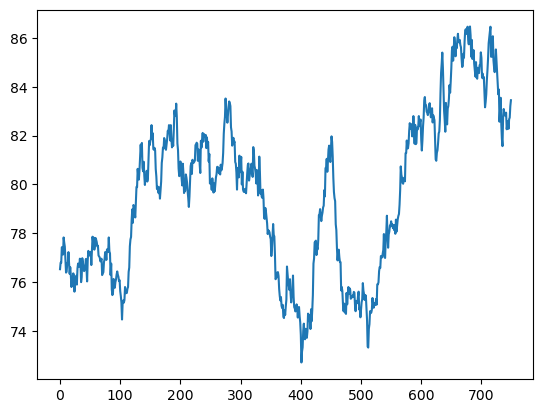

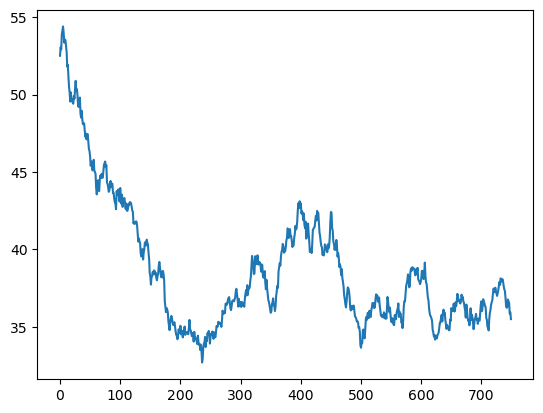

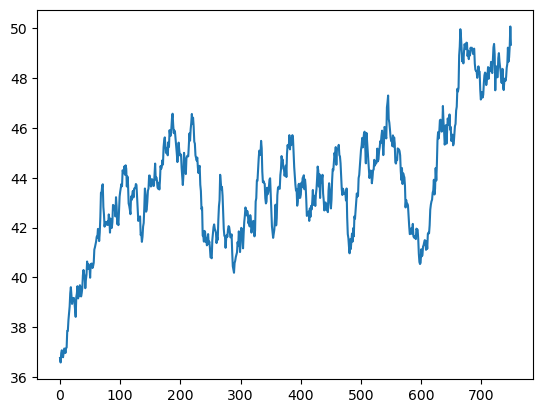

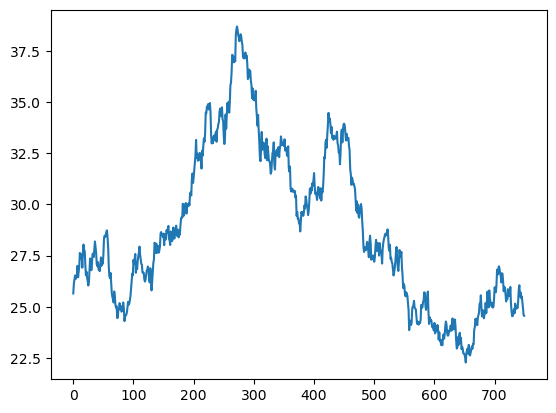

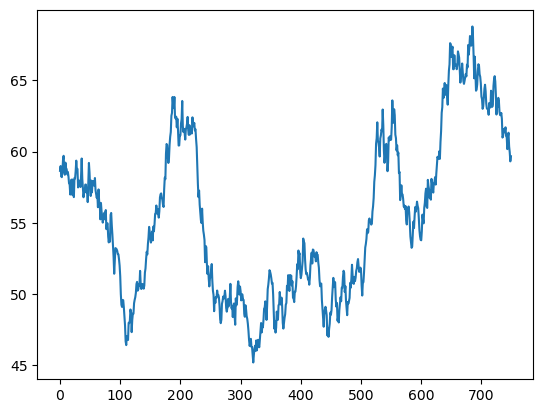

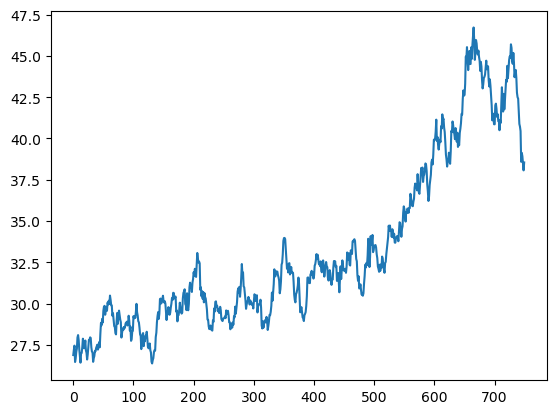

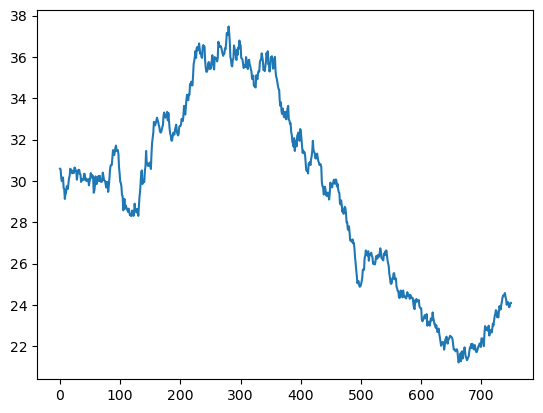

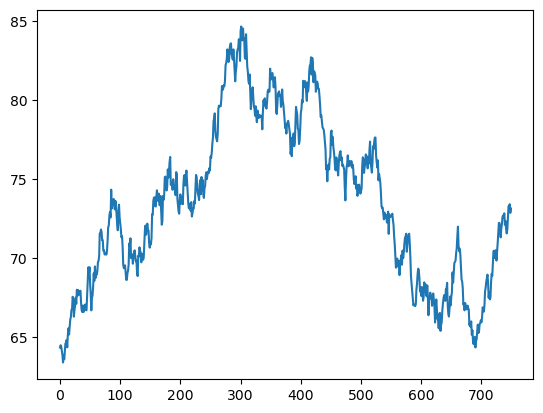

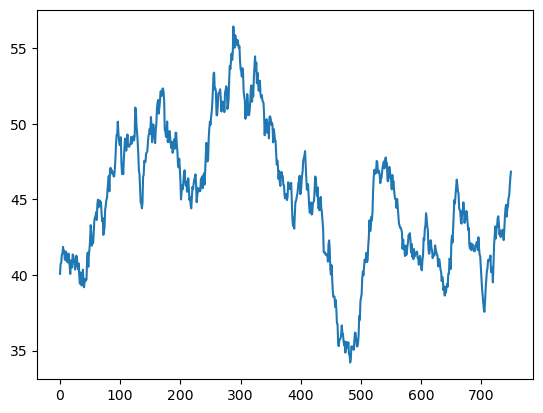

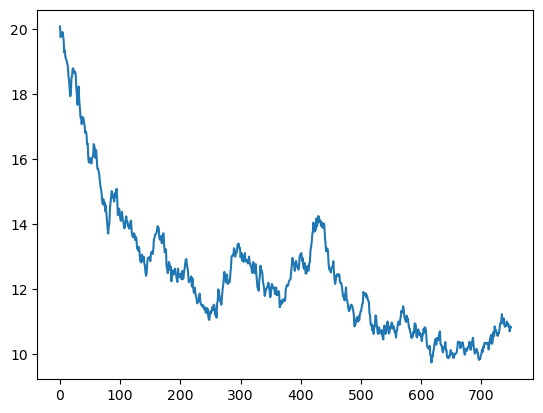

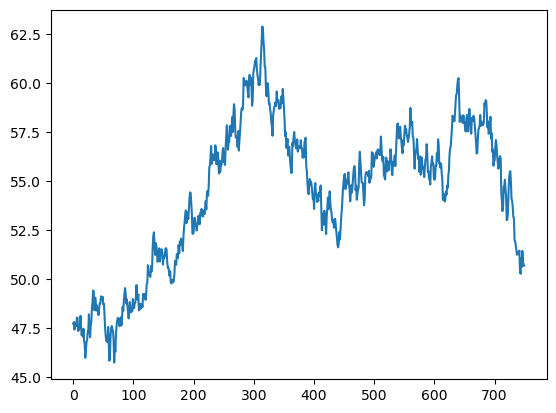

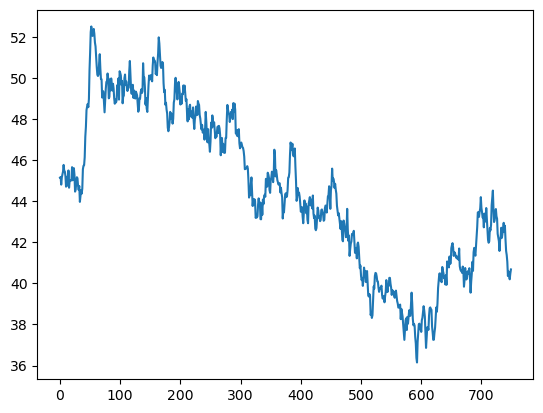

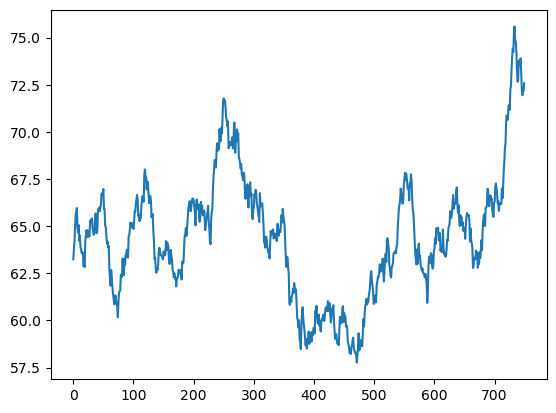

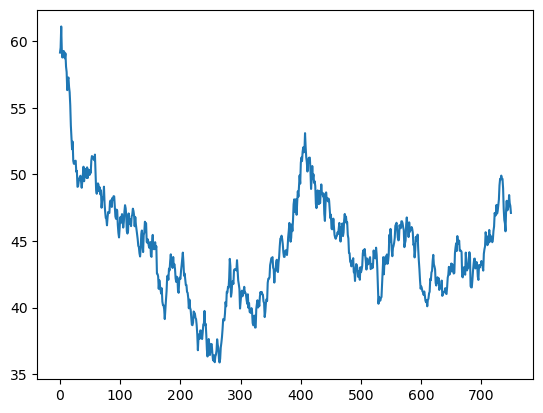

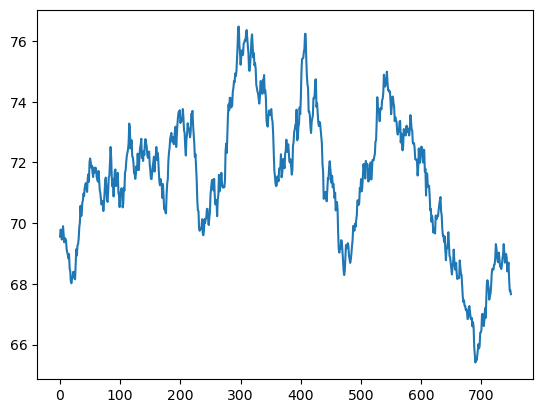

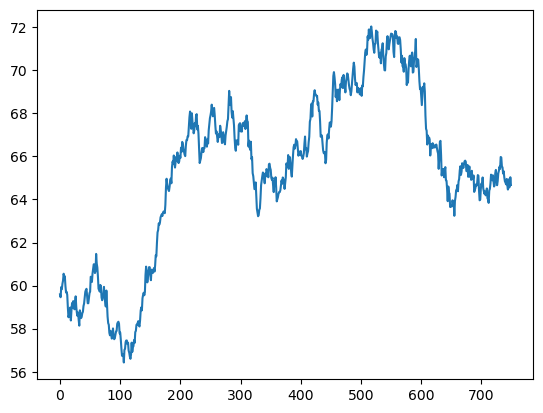

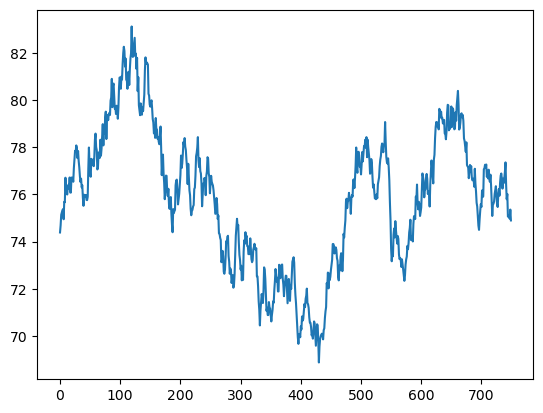

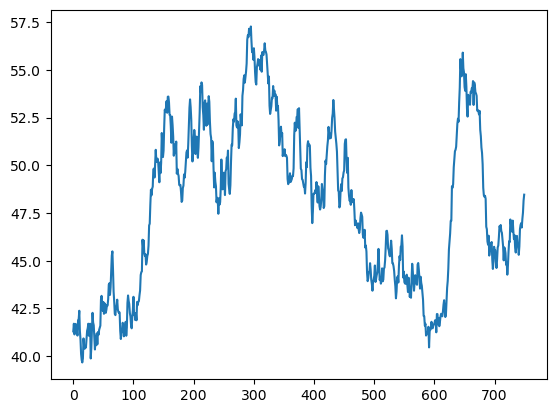

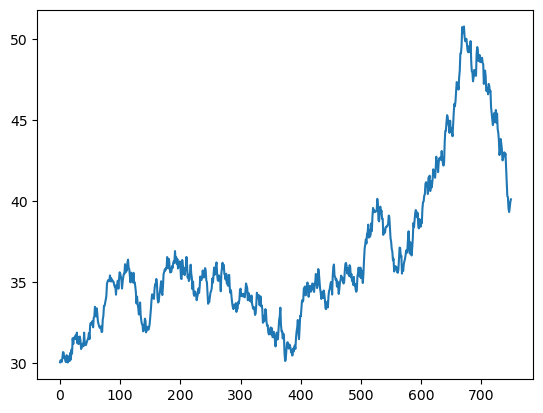

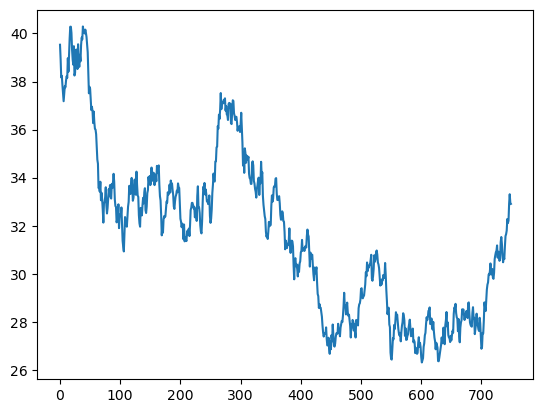

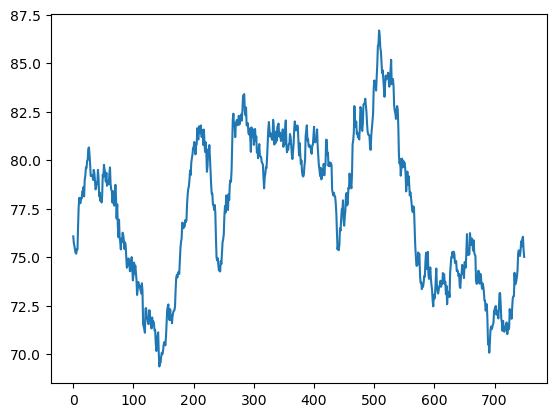

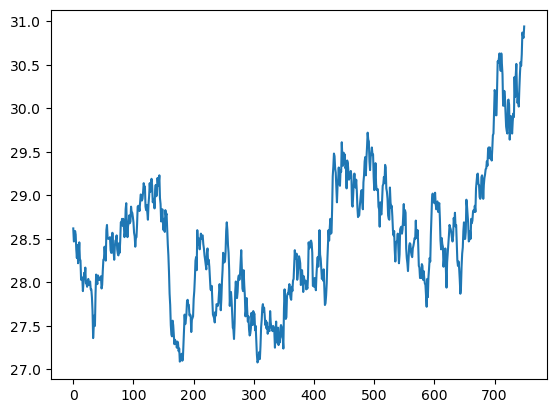

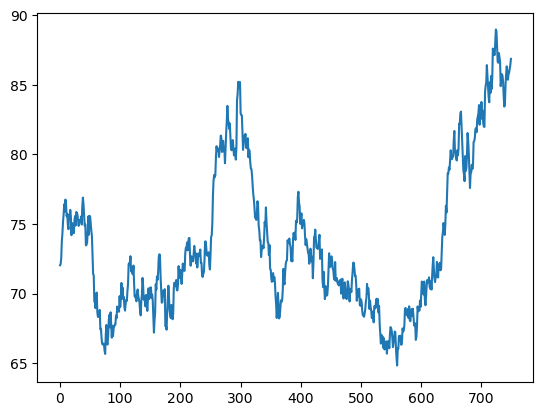

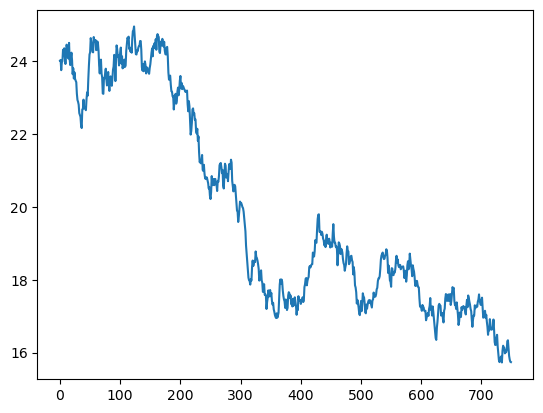

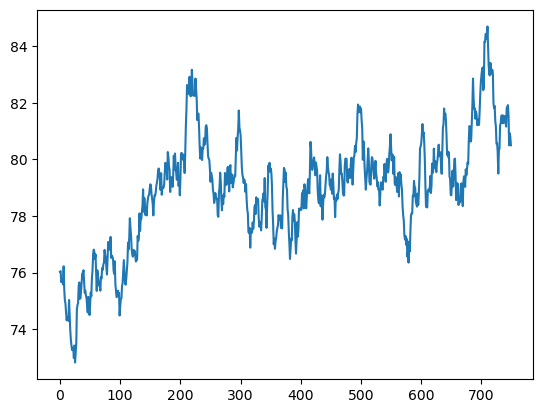

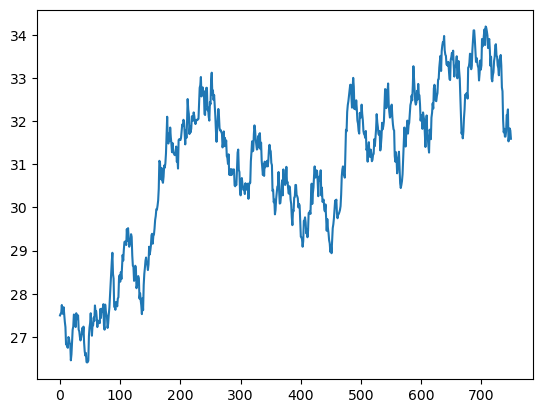

In [6]:
for i in range(50):
    plt.plot(d[i,:])
    plt.show()

In [7]:
returns = np.diff(np.log(d),axis = 1)

In [8]:
returns

array([[-0.00366685, -0.0055256 , -0.0068838 , ...,  0.0076839 ,
        -0.00410903, -0.00522913],
       [ 0.01323379, -0.0060198 , -0.00244692, ..., -0.00294841,
         0.00764785, -0.01080242],
       [ 0.00498113,  0.00686849,  0.00697972, ..., -0.00922287,
        -0.0052113 , -0.01349363],
       ...,
       [ 0.00083229, -0.01171562,  0.00879955, ..., -0.00630519,
        -0.00380229, -0.00063512],
       [ 0.00026302, -0.0051414 ,  0.00066063, ...,  0.0053274 ,
        -0.00160762, -0.00371978],
       [ 0.00145349,  0.00036304,  0.00687288, ...,  0.00567109,
        -0.00157208, -0.00599655]])

In [9]:
cor_matrix = np.corrcoef(returns)

In [10]:
cor_matrix

array([[ 1.00000000e+00,  4.36759450e-02,  2.05027598e-02, ...,
         5.96425928e-02, -3.15266153e-02, -1.75141909e-02],
       [ 4.36759450e-02,  1.00000000e+00, -5.23157236e-02, ...,
         3.60833873e-02, -4.61817165e-02,  2.37724744e-02],
       [ 2.05027598e-02, -5.23157236e-02,  1.00000000e+00, ...,
        -1.50047074e-04,  7.12972797e-02,  6.91012684e-02],
       ...,
       [ 5.96425928e-02,  3.60833873e-02, -1.50047074e-04, ...,
         1.00000000e+00,  4.94240221e-02, -2.79210076e-02],
       [-3.15266153e-02, -4.61817165e-02,  7.12972797e-02, ...,
         4.94240221e-02,  1.00000000e+00, -4.32052031e-02],
       [-1.75141909e-02,  2.37724744e-02,  6.91012684e-02, ...,
        -2.79210076e-02, -4.32052031e-02,  1.00000000e+00]])

In [77]:
def top_corr(cor_mat, top_n = 10):
    n = cor_mat.shape[0]
    pairs = []
    for i in range(n):
        for j in range(i+1,n):
            pairs.append(((i,j),cor_mat[i,j]))
    pairs = sorted(pairs, key = lambda x: abs(x[1]), reverse = True)
    return pairs[:top_n]

In [79]:
top_pairs = top_corr(cor_matrix)
top_pairs

[((18, 38), 0.12795814962711188),
 ((31, 41), 0.11705315019571079),
 ((7, 38), 0.11477600824910293),
 ((13, 17), 0.1103206234153869),
 ((23, 36), 0.10839963428100513),
 ((38, 39), 0.10802805870982843),
 ((13, 38), 0.10743130819158461),
 ((8, 36), -0.10219120916805213),
 ((9, 13), 0.10159821443970733),
 ((12, 17), 0.09908708497303578)]

In [81]:
def compute_spread_zscore(p1, p2):
    beta = np.polyfit(p1, p2, 1)[0]  # Linear regression slope
    spread = p2 - beta * p1
    z = (spread - np.mean(spread)) / np.std(spread)
    return spread, z, beta

def simulate_trades(z, entry=1.0, exit=0.0):
    positions = np.zeros(len(z))
    for t in range(1, len(z)):
        if z[t-1] < -entry:
            positions[t] = 1  # Long spread: Long B, short A
        elif z[t-1] > entry:
            positions[t] = -1  # Short spread
        elif abs(z[t-1]) < exit:
            positions[t] = 0  # Exit
        else:
            positions[t] = positions[t-1]  # Hold position
    return positions

def compute_pnl(positions, spread):
    spread_diff = np.diff(spread)
    pnl = positions[:-1] * spread_diff  # Lag the position by 1
    return np.cumsum(pnl)


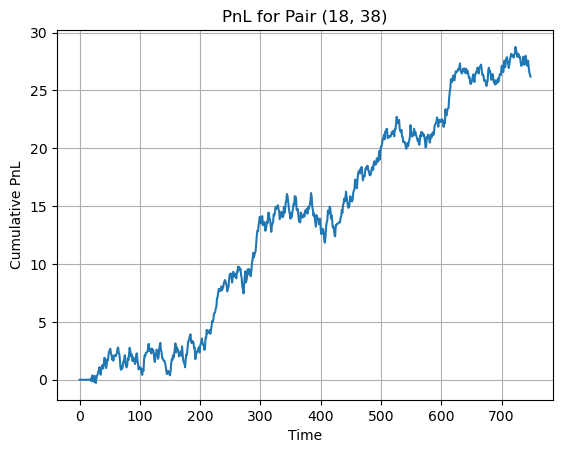

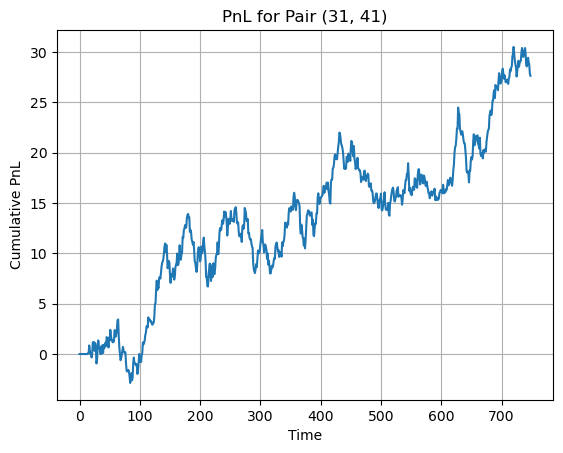

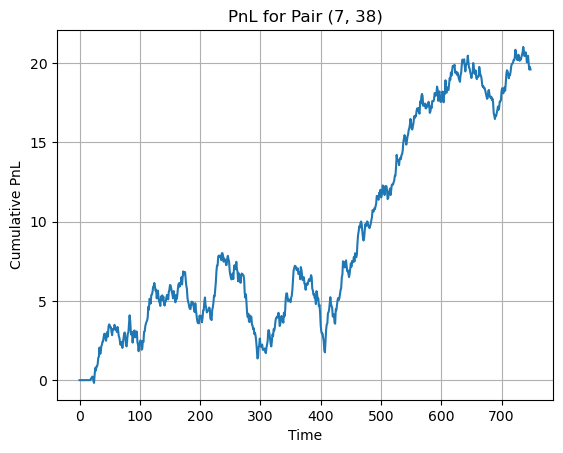

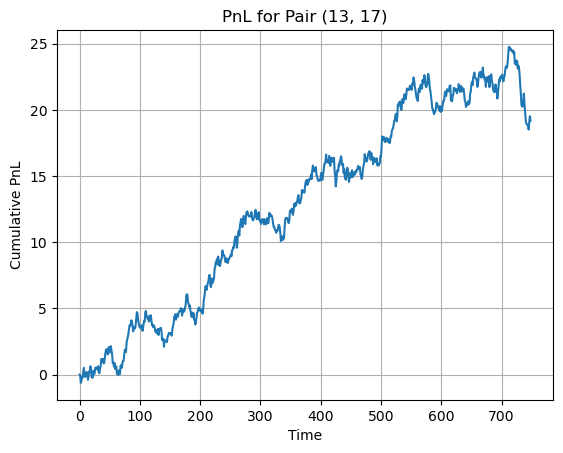

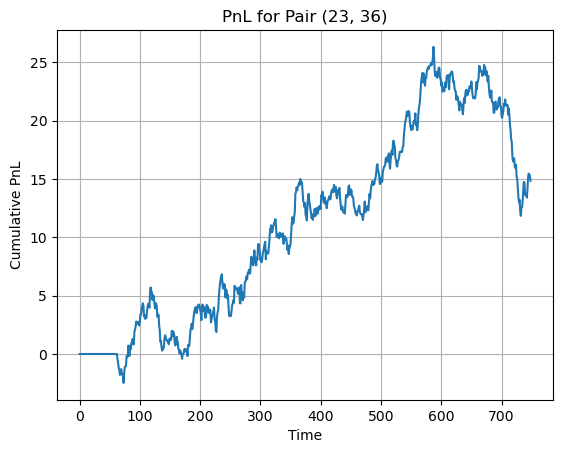

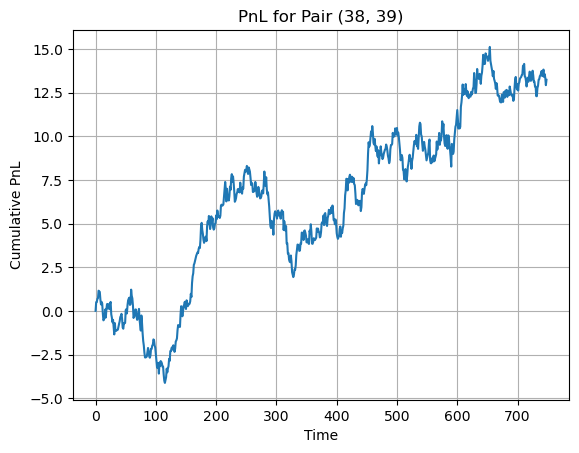

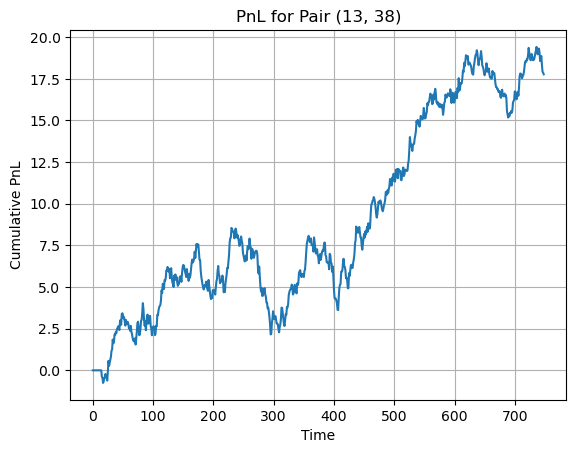

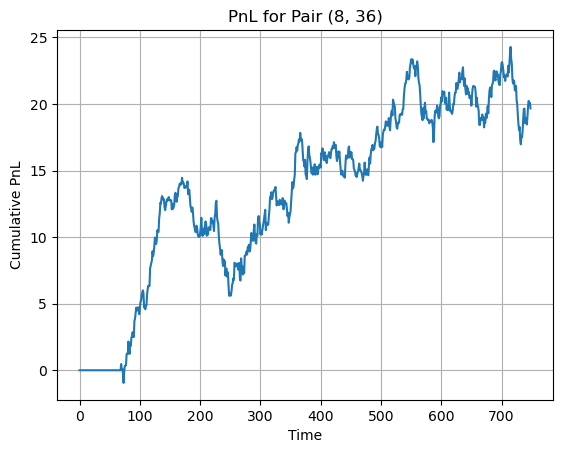

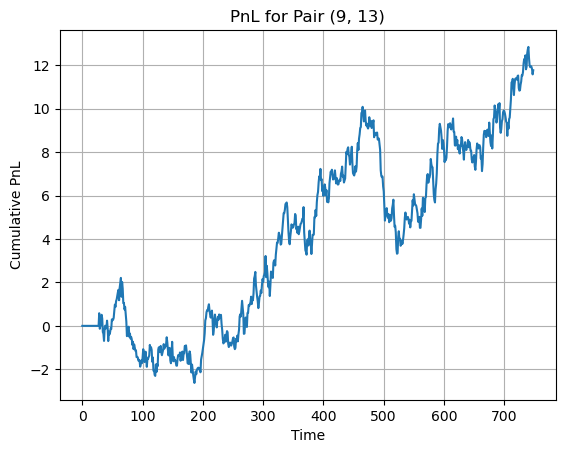

In [14]:
for a in range(9):
    i, j = top_pairs[a][0]
    p1 = d[i]
    p2 = d[j]
    
    spread, z, beta = compute_spread_zscore(p1, p2)
    positions = simulate_trades(z)
    pnl = compute_pnl(positions, spread)
    plt.plot(pnl)
    plt.title(f"PnL for Pair ({i}, {j})")
    plt.xlabel("Time")
    plt.ylabel("Cumulative PnL")
    plt.grid(True)
    plt.show()


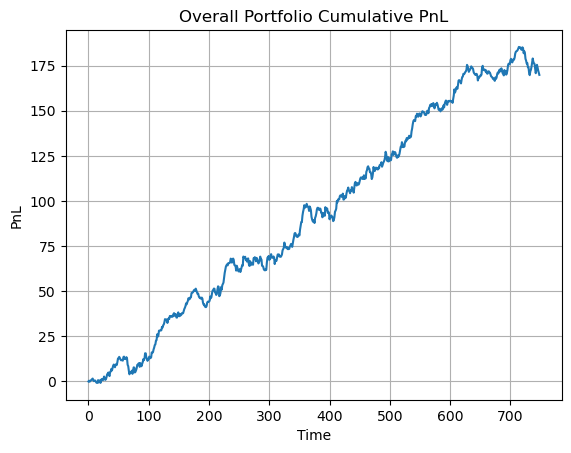

In [15]:
overall_pnl = None

for a in range(9):  # Or len(top_pairs)
    i, j = top_pairs[a][0]
    p1 = d[i]
    p2 = d[j]

    spread, z, beta = compute_spread_zscore(p1, p2)
    positions = simulate_trades(z)
    pnl = compute_pnl(positions, spread)

    # Pad pnl to the same length if needed
    pnl = np.pad(pnl, (0, d.shape[1] - 1 - len(pnl)), constant_values=0)

    if overall_pnl is None:
        overall_pnl = pnl
    else:
        overall_pnl += pnl  # aggregate all pnls into one

# Plot the overall portfolio PnL
plt.plot(overall_pnl)
plt.title("Overall Portfolio Cumulative PnL")
plt.xlabel("Time")
plt.ylabel("PnL")
plt.grid(True)
plt.show()


In [35]:
def analyze_pnl(pnl):
    returns = np.diff(pnl)
    avg_daily_return = np.mean(returns)
    volatility = np.std(returns)
    sharpe_ratio = avg_daily_return / volatility * np.sqrt(252)  # assume 252 trading days
    max_drawdown = np.max(np.maximum.accumulate(pnl) - pnl)

    print(f"Total PnL: {pnl[-1]:.2f}")
    print(f"Average Daily Return: {avg_daily_return:.4f}")
    print(f"Volatility: {volatility:.4f}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Max Drawdown: {max_drawdown:.2f}")
    print(f"Final score: {avg_daily_return-0.1*volatility}")

analyze_pnl(overall_pnl)



Total PnL: 169.88
Average Daily Return: 0.2271
Volatility: 1.3744
Sharpe Ratio: 2.62
Max Drawdown: 15.65
Final score: 0.08966422544444813


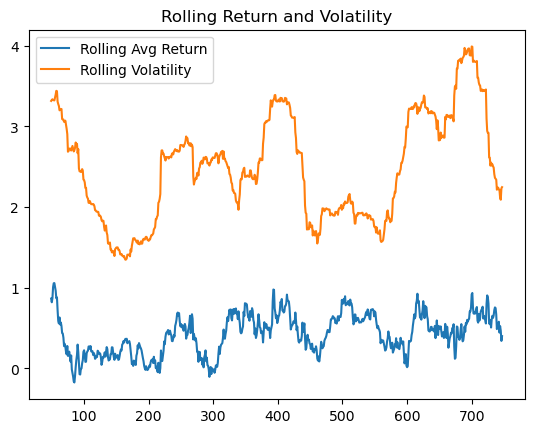

In [107]:
rolling_window = 50
rolling_returns = pd.Series(np.diff(overall_pnl)).rolling(rolling_window)

plt.plot(rolling_returns.mean(), label="Rolling Avg Return")
plt.plot(rolling_returns.std(), label="Rolling Volatility")
plt.legend()
plt.title("Rolling Return and Volatility")
plt.show()